In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        #self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(128, 128)
        #self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(128, 10)
        #self.fc3 = nn.Linear(1000, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
            #self.bn = nn.BatchNorm1d(1000)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
               
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
acc_train_m=[]
acc_train_m_loss=[]
def train(epoch, models):
    train_size = len(train_loader.sampler)
    correct = [0]*len(models)
    for batch_idx, (data, target) in enumerate(train_loader):
        for i, model in enumerate(models): #model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()            
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_pct = [100. * c / train_size for c in correct]
        
        #([correct_pct[i] for i in range(len(models))])
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
        print(line + losses)
    
    acc_train_m.append(correct_pct)
    acc_train_m_loss.append(models[0]._loss.item())

In [5]:
#models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]
models = [Net(True, False)]

In [6]:
acc_test_m=[]
acc_test_m_loss=[]
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    acc_test_m.append(correct_pct)
    acc_test_m_loss.append(test_loss[0])
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)

In [7]:
for epoch in range(1, 101):
    for model in models:
        model.train()
    train(epoch, models)
    for model in models:
        model.eval()
    test(models, valid_loader)

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.334198
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 1.828303
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 1.100020
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.842969
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.589616
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.247129
Test set:
0: Loss: 0.8841	Accuracy: 7079/10000 (70%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.203974
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.180111
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.186606
Train Epoch: 2 [30000/50000 (60%)]	Losses 0: 0.458855
Train Epoch: 2 [40000/50000 (80%)]	Losses 0: 0.511146
Train Epoch: 2 [50000/50000 (100%)]	Losses 0: 0.191559
Test set:
0: Loss: 1.0009	Accuracy: 6283/10000 (62%)

Train Epoch: 3 [0/50000 (0%)]	Losses 0: 0.233042
Train Epoch: 3 [10000/50000 (20%)]	Losses 0: 0.102776
Train Epoch: 3 [20000/50000 (40%)]	Losses 0: 0.179786
Train Epoch: 3 [30000/50000 (60%)]	Losses 0: 0.340540
Train Epoch: 3 [40000/50000 (80%)]	Losses

Train Epoch: 22 [40000/50000 (80%)]	Losses 0: 0.027413
Train Epoch: 22 [50000/50000 (100%)]	Losses 0: 0.000935
Test set:
0: Loss: 0.4911	Accuracy: 8333/10000 (83%)

Train Epoch: 23 [0/50000 (0%)]	Losses 0: 0.037142
Train Epoch: 23 [10000/50000 (20%)]	Losses 0: 0.002371
Train Epoch: 23 [20000/50000 (40%)]	Losses 0: 0.076105
Train Epoch: 23 [30000/50000 (60%)]	Losses 0: 0.039663
Train Epoch: 23 [40000/50000 (80%)]	Losses 0: 0.068321
Train Epoch: 23 [50000/50000 (100%)]	Losses 0: 0.082145
Test set:
0: Loss: 0.4475	Accuracy: 8634/10000 (86%)

Train Epoch: 24 [0/50000 (0%)]	Losses 0: 0.008301
Train Epoch: 24 [10000/50000 (20%)]	Losses 0: 0.005606
Train Epoch: 24 [20000/50000 (40%)]	Losses 0: 0.052243
Train Epoch: 24 [30000/50000 (60%)]	Losses 0: 0.105085
Train Epoch: 24 [40000/50000 (80%)]	Losses 0: 0.064834
Train Epoch: 24 [50000/50000 (100%)]	Losses 0: 0.011678
Test set:
0: Loss: 0.4698	Accuracy: 8428/10000 (84%)

Train Epoch: 25 [0/50000 (0%)]	Losses 0: 0.013546
Train Epoch: 25 [10000/50

Train Epoch: 44 [0/50000 (0%)]	Losses 0: 0.015358
Train Epoch: 44 [10000/50000 (20%)]	Losses 0: 0.048260
Train Epoch: 44 [20000/50000 (40%)]	Losses 0: 0.014305
Train Epoch: 44 [30000/50000 (60%)]	Losses 0: 0.000751
Train Epoch: 44 [40000/50000 (80%)]	Losses 0: 0.076269
Train Epoch: 44 [50000/50000 (100%)]	Losses 0: 0.043067
Test set:
0: Loss: 0.3331	Accuracy: 9000/10000 (90%)

Train Epoch: 45 [0/50000 (0%)]	Losses 0: 0.019139
Train Epoch: 45 [10000/50000 (20%)]	Losses 0: 0.005464
Train Epoch: 45 [20000/50000 (40%)]	Losses 0: 0.001391
Train Epoch: 45 [30000/50000 (60%)]	Losses 0: 0.006996
Train Epoch: 45 [40000/50000 (80%)]	Losses 0: 0.038050
Train Epoch: 45 [50000/50000 (100%)]	Losses 0: 0.000187
Test set:
0: Loss: 0.4123	Accuracy: 8879/10000 (88%)

Train Epoch: 46 [0/50000 (0%)]	Losses 0: 0.004142
Train Epoch: 46 [10000/50000 (20%)]	Losses 0: 0.006104
Train Epoch: 46 [20000/50000 (40%)]	Losses 0: 0.031896
Train Epoch: 46 [30000/50000 (60%)]	Losses 0: 0.012644
Train Epoch: 46 [40000/50

Train Epoch: 65 [30000/50000 (60%)]	Losses 0: 0.000688
Train Epoch: 65 [40000/50000 (80%)]	Losses 0: 0.006462
Train Epoch: 65 [50000/50000 (100%)]	Losses 0: 0.000401
Test set:
0: Loss: 0.3482	Accuracy: 8981/10000 (89%)

Train Epoch: 66 [0/50000 (0%)]	Losses 0: 0.000196
Train Epoch: 66 [10000/50000 (20%)]	Losses 0: 0.000139
Train Epoch: 66 [20000/50000 (40%)]	Losses 0: 0.000276
Train Epoch: 66 [30000/50000 (60%)]	Losses 0: 0.003238
Train Epoch: 66 [40000/50000 (80%)]	Losses 0: 0.001801
Train Epoch: 66 [50000/50000 (100%)]	Losses 0: 0.000653
Test set:
0: Loss: 0.3244	Accuracy: 9073/10000 (90%)

Train Epoch: 67 [0/50000 (0%)]	Losses 0: 0.005056
Train Epoch: 67 [10000/50000 (20%)]	Losses 0: 0.004281
Train Epoch: 67 [20000/50000 (40%)]	Losses 0: 0.001642
Train Epoch: 67 [30000/50000 (60%)]	Losses 0: 0.005690
Train Epoch: 67 [40000/50000 (80%)]	Losses 0: 0.005025
Train Epoch: 67 [50000/50000 (100%)]	Losses 0: 0.000284
Test set:
0: Loss: 0.3952	Accuracy: 8863/10000 (88%)

Train Epoch: 68 [0/5


Train Epoch: 87 [0/50000 (0%)]	Losses 0: 0.001457
Train Epoch: 87 [10000/50000 (20%)]	Losses 0: 0.000493
Train Epoch: 87 [20000/50000 (40%)]	Losses 0: 0.000517
Train Epoch: 87 [30000/50000 (60%)]	Losses 0: 0.003837
Train Epoch: 87 [40000/50000 (80%)]	Losses 0: 0.000024
Train Epoch: 87 [50000/50000 (100%)]	Losses 0: 0.008720
Test set:
0: Loss: 0.3280	Accuracy: 9029/10000 (90%)

Train Epoch: 88 [0/50000 (0%)]	Losses 0: 0.002015
Train Epoch: 88 [10000/50000 (20%)]	Losses 0: 0.000563
Train Epoch: 88 [20000/50000 (40%)]	Losses 0: 0.001026
Train Epoch: 88 [30000/50000 (60%)]	Losses 0: 0.003421
Train Epoch: 88 [40000/50000 (80%)]	Losses 0: 0.000741
Train Epoch: 88 [50000/50000 (100%)]	Losses 0: 0.003512
Test set:
0: Loss: 0.2574	Accuracy: 9231/10000 (92%)

Train Epoch: 89 [0/50000 (0%)]	Losses 0: 0.000658
Train Epoch: 89 [10000/50000 (20%)]	Losses 0: 0.000117
Train Epoch: 89 [20000/50000 (40%)]	Losses 0: 0.000487
Train Epoch: 89 [30000/50000 (60%)]	Losses 0: 0.000958
Train Epoch: 89 [40000/5

In [18]:
for epoch in range(101, 301):
    for model in models:
        model.train()
    train(epoch, models)
    for model in models:
        model.eval()
    test(models, valid_loader)

Train Epoch: 101 [0/50000 (0%)]	Losses 0: 0.003574
Train Epoch: 101 [10000/50000 (20%)]	Losses 0: 0.022194
Train Epoch: 101 [20000/50000 (40%)]	Losses 0: 0.058859
Train Epoch: 101 [30000/50000 (60%)]	Losses 0: 0.000123
Train Epoch: 101 [40000/50000 (80%)]	Losses 0: 0.031095
Train Epoch: 101 [50000/50000 (100%)]	Losses 0: 0.000627
Test set:
0: Loss: 0.3483	Accuracy: 8969/10000 (89%)

Train Epoch: 102 [0/50000 (0%)]	Losses 0: 0.000272
Train Epoch: 102 [10000/50000 (20%)]	Losses 0: 0.000701
Train Epoch: 102 [20000/50000 (40%)]	Losses 0: 0.000010
Train Epoch: 102 [30000/50000 (60%)]	Losses 0: 0.000642
Train Epoch: 102 [40000/50000 (80%)]	Losses 0: 0.000241
Train Epoch: 102 [50000/50000 (100%)]	Losses 0: 0.003011
Test set:
0: Loss: 0.3988	Accuracy: 8770/10000 (87%)

Train Epoch: 103 [0/50000 (0%)]	Losses 0: 0.000414
Train Epoch: 103 [10000/50000 (20%)]	Losses 0: 0.000310
Train Epoch: 103 [20000/50000 (40%)]	Losses 0: 0.001550
Train Epoch: 103 [30000/50000 (60%)]	Losses 0: 0.003482
Train Epo

Train Epoch: 122 [10000/50000 (20%)]	Losses 0: 0.001148
Train Epoch: 122 [20000/50000 (40%)]	Losses 0: 0.009746
Train Epoch: 122 [30000/50000 (60%)]	Losses 0: 0.004651
Train Epoch: 122 [40000/50000 (80%)]	Losses 0: 0.000186
Train Epoch: 122 [50000/50000 (100%)]	Losses 0: 0.002905
Test set:
0: Loss: 0.5079	Accuracy: 8454/10000 (84%)

Train Epoch: 123 [0/50000 (0%)]	Losses 0: 0.032121
Train Epoch: 123 [10000/50000 (20%)]	Losses 0: 0.000499
Train Epoch: 123 [20000/50000 (40%)]	Losses 0: 0.001466
Train Epoch: 123 [30000/50000 (60%)]	Losses 0: 0.005181
Train Epoch: 123 [40000/50000 (80%)]	Losses 0: 0.000098
Train Epoch: 123 [50000/50000 (100%)]	Losses 0: 0.000170
Test set:
0: Loss: 0.4781	Accuracy: 8496/10000 (84%)

Train Epoch: 124 [0/50000 (0%)]	Losses 0: 0.000534
Train Epoch: 124 [10000/50000 (20%)]	Losses 0: 0.001755
Train Epoch: 124 [20000/50000 (40%)]	Losses 0: 0.043177
Train Epoch: 124 [30000/50000 (60%)]	Losses 0: 0.001307
Train Epoch: 124 [40000/50000 (80%)]	Losses 0: 0.000058
Trai

Train Epoch: 143 [20000/50000 (40%)]	Losses 0: 0.000089
Train Epoch: 143 [30000/50000 (60%)]	Losses 0: 0.005795
Train Epoch: 143 [40000/50000 (80%)]	Losses 0: 0.000181
Train Epoch: 143 [50000/50000 (100%)]	Losses 0: 0.000124
Test set:
0: Loss: 0.3740	Accuracy: 8825/10000 (88%)

Train Epoch: 144 [0/50000 (0%)]	Losses 0: 0.000055
Train Epoch: 144 [10000/50000 (20%)]	Losses 0: 0.000020
Train Epoch: 144 [20000/50000 (40%)]	Losses 0: 0.000886
Train Epoch: 144 [30000/50000 (60%)]	Losses 0: 0.001010
Train Epoch: 144 [40000/50000 (80%)]	Losses 0: 0.000823
Train Epoch: 144 [50000/50000 (100%)]	Losses 0: 0.000608
Test set:
0: Loss: 0.4236	Accuracy: 8700/10000 (87%)

Train Epoch: 145 [0/50000 (0%)]	Losses 0: 0.000313
Train Epoch: 145 [10000/50000 (20%)]	Losses 0: 0.000341
Train Epoch: 145 [20000/50000 (40%)]	Losses 0: 0.000206
Train Epoch: 145 [30000/50000 (60%)]	Losses 0: 0.000031
Train Epoch: 145 [40000/50000 (80%)]	Losses 0: 0.000416
Train Epoch: 145 [50000/50000 (100%)]	Losses 0: 0.016579
Tes

Train Epoch: 164 [30000/50000 (60%)]	Losses 0: 0.000065
Train Epoch: 164 [40000/50000 (80%)]	Losses 0: 0.031765
Train Epoch: 164 [50000/50000 (100%)]	Losses 0: 0.004429
Test set:
0: Loss: 0.5033	Accuracy: 8374/10000 (83%)

Train Epoch: 165 [0/50000 (0%)]	Losses 0: 0.000492
Train Epoch: 165 [10000/50000 (20%)]	Losses 0: 0.007154
Train Epoch: 165 [20000/50000 (40%)]	Losses 0: 0.001669
Train Epoch: 165 [30000/50000 (60%)]	Losses 0: 0.005182
Train Epoch: 165 [40000/50000 (80%)]	Losses 0: 0.000091
Train Epoch: 165 [50000/50000 (100%)]	Losses 0: 0.000046
Test set:
0: Loss: 0.4001	Accuracy: 8846/10000 (88%)

Train Epoch: 166 [0/50000 (0%)]	Losses 0: 0.000188
Train Epoch: 166 [10000/50000 (20%)]	Losses 0: 0.010395
Train Epoch: 166 [20000/50000 (40%)]	Losses 0: 0.019997
Train Epoch: 166 [30000/50000 (60%)]	Losses 0: 0.000061
Train Epoch: 166 [40000/50000 (80%)]	Losses 0: 0.000358
Train Epoch: 166 [50000/50000 (100%)]	Losses 0: 0.001557
Test set:
0: Loss: 0.5213	Accuracy: 8414/10000 (84%)

Train

Train Epoch: 185 [40000/50000 (80%)]	Losses 0: 0.000017
Train Epoch: 185 [50000/50000 (100%)]	Losses 0: 0.000069
Test set:
0: Loss: 0.2534	Accuracy: 9277/10000 (92%)

Train Epoch: 186 [0/50000 (0%)]	Losses 0: 0.000496
Train Epoch: 186 [10000/50000 (20%)]	Losses 0: 0.000131
Train Epoch: 186 [20000/50000 (40%)]	Losses 0: 0.000030
Train Epoch: 186 [30000/50000 (60%)]	Losses 0: 0.000273
Train Epoch: 186 [40000/50000 (80%)]	Losses 0: 0.000015
Train Epoch: 186 [50000/50000 (100%)]	Losses 0: 0.049490
Test set:
0: Loss: 0.3027	Accuracy: 9139/10000 (91%)

Train Epoch: 187 [0/50000 (0%)]	Losses 0: 0.000054
Train Epoch: 187 [10000/50000 (20%)]	Losses 0: 0.000121
Train Epoch: 187 [20000/50000 (40%)]	Losses 0: 0.000010
Train Epoch: 187 [30000/50000 (60%)]	Losses 0: 0.053691
Train Epoch: 187 [40000/50000 (80%)]	Losses 0: 0.030875
Train Epoch: 187 [50000/50000 (100%)]	Losses 0: 0.000062
Test set:
0: Loss: 0.3754	Accuracy: 8847/10000 (88%)

Train Epoch: 188 [0/50000 (0%)]	Losses 0: 0.000679
Train Epoc

Train Epoch: 206 [50000/50000 (100%)]	Losses 0: 0.000025
Test set:
0: Loss: 0.3496	Accuracy: 8955/10000 (89%)

Train Epoch: 207 [0/50000 (0%)]	Losses 0: 0.000087
Train Epoch: 207 [10000/50000 (20%)]	Losses 0: 0.000392
Train Epoch: 207 [20000/50000 (40%)]	Losses 0: 0.000094
Train Epoch: 207 [30000/50000 (60%)]	Losses 0: 0.095454
Train Epoch: 207 [40000/50000 (80%)]	Losses 0: 0.000717
Train Epoch: 207 [50000/50000 (100%)]	Losses 0: 0.000042
Test set:
0: Loss: 0.3692	Accuracy: 8957/10000 (89%)

Train Epoch: 208 [0/50000 (0%)]	Losses 0: 0.000015
Train Epoch: 208 [10000/50000 (20%)]	Losses 0: 0.000077
Train Epoch: 208 [20000/50000 (40%)]	Losses 0: 0.001925
Train Epoch: 208 [30000/50000 (60%)]	Losses 0: 0.000119
Train Epoch: 208 [40000/50000 (80%)]	Losses 0: 0.000996
Train Epoch: 208 [50000/50000 (100%)]	Losses 0: 0.000294
Test set:
0: Loss: 0.3074	Accuracy: 9116/10000 (91%)

Train Epoch: 209 [0/50000 (0%)]	Losses 0: 0.001008
Train Epoch: 209 [10000/50000 (20%)]	Losses 0: 0.000423
Train Epoc


Train Epoch: 228 [0/50000 (0%)]	Losses 0: 0.000003
Train Epoch: 228 [10000/50000 (20%)]	Losses 0: 0.000035
Train Epoch: 228 [20000/50000 (40%)]	Losses 0: 0.000110
Train Epoch: 228 [30000/50000 (60%)]	Losses 0: 0.000028
Train Epoch: 228 [40000/50000 (80%)]	Losses 0: 0.000694
Train Epoch: 228 [50000/50000 (100%)]	Losses 0: 0.000078
Test set:
0: Loss: 0.3762	Accuracy: 8866/10000 (88%)

Train Epoch: 229 [0/50000 (0%)]	Losses 0: 0.002911
Train Epoch: 229 [10000/50000 (20%)]	Losses 0: 0.000006
Train Epoch: 229 [20000/50000 (40%)]	Losses 0: 0.001541
Train Epoch: 229 [30000/50000 (60%)]	Losses 0: 0.000032
Train Epoch: 229 [40000/50000 (80%)]	Losses 0: 0.000045
Train Epoch: 229 [50000/50000 (100%)]	Losses 0: 0.000166
Test set:
0: Loss: 0.3513	Accuracy: 8898/10000 (88%)

Train Epoch: 230 [0/50000 (0%)]	Losses 0: 0.000013
Train Epoch: 230 [10000/50000 (20%)]	Losses 0: 0.000042
Train Epoch: 230 [20000/50000 (40%)]	Losses 0: 0.000284
Train Epoch: 230 [30000/50000 (60%)]	Losses 0: 0.000020
Train Ep

Train Epoch: 249 [10000/50000 (20%)]	Losses 0: 0.000038
Train Epoch: 249 [20000/50000 (40%)]	Losses 0: 0.000030
Train Epoch: 249 [30000/50000 (60%)]	Losses 0: 0.000012
Train Epoch: 249 [40000/50000 (80%)]	Losses 0: 0.000450
Train Epoch: 249 [50000/50000 (100%)]	Losses 0: 0.000767
Test set:
0: Loss: 0.3331	Accuracy: 8937/10000 (89%)

Train Epoch: 250 [0/50000 (0%)]	Losses 0: 0.000177
Train Epoch: 250 [10000/50000 (20%)]	Losses 0: 0.000406
Train Epoch: 250 [20000/50000 (40%)]	Losses 0: 0.000145
Train Epoch: 250 [30000/50000 (60%)]	Losses 0: 0.050821
Train Epoch: 250 [40000/50000 (80%)]	Losses 0: 0.000059
Train Epoch: 250 [50000/50000 (100%)]	Losses 0: 0.000005
Test set:
0: Loss: 0.4266	Accuracy: 8716/10000 (87%)

Train Epoch: 251 [0/50000 (0%)]	Losses 0: 0.000120
Train Epoch: 251 [10000/50000 (20%)]	Losses 0: 0.038595
Train Epoch: 251 [20000/50000 (40%)]	Losses 0: 0.000101
Train Epoch: 251 [30000/50000 (60%)]	Losses 0: 0.000023
Train Epoch: 251 [40000/50000 (80%)]	Losses 0: 0.052492
Trai

Train Epoch: 270 [20000/50000 (40%)]	Losses 0: 0.000572
Train Epoch: 270 [30000/50000 (60%)]	Losses 0: 0.000014
Train Epoch: 270 [40000/50000 (80%)]	Losses 0: 0.000140
Train Epoch: 270 [50000/50000 (100%)]	Losses 0: 0.000522
Test set:
0: Loss: 0.2882	Accuracy: 9189/10000 (91%)

Train Epoch: 271 [0/50000 (0%)]	Losses 0: 0.000005
Train Epoch: 271 [10000/50000 (20%)]	Losses 0: 0.000342
Train Epoch: 271 [20000/50000 (40%)]	Losses 0: 0.001135
Train Epoch: 271 [30000/50000 (60%)]	Losses 0: 0.000082
Train Epoch: 271 [40000/50000 (80%)]	Losses 0: 0.000425
Train Epoch: 271 [50000/50000 (100%)]	Losses 0: 0.000006
Test set:
0: Loss: 0.3052	Accuracy: 9099/10000 (90%)

Train Epoch: 272 [0/50000 (0%)]	Losses 0: 0.000016
Train Epoch: 272 [10000/50000 (20%)]	Losses 0: 0.000068
Train Epoch: 272 [20000/50000 (40%)]	Losses 0: 0.000016
Train Epoch: 272 [30000/50000 (60%)]	Losses 0: 0.000004
Train Epoch: 272 [40000/50000 (80%)]	Losses 0: 0.000025
Train Epoch: 272 [50000/50000 (100%)]	Losses 0: 0.003844
Tes

Train Epoch: 291 [30000/50000 (60%)]	Losses 0: 0.000392
Train Epoch: 291 [40000/50000 (80%)]	Losses 0: 0.000636
Train Epoch: 291 [50000/50000 (100%)]	Losses 0: 0.000140
Test set:
0: Loss: 0.2683	Accuracy: 9234/10000 (92%)

Train Epoch: 292 [0/50000 (0%)]	Losses 0: 0.000113
Train Epoch: 292 [10000/50000 (20%)]	Losses 0: 0.000026
Train Epoch: 292 [20000/50000 (40%)]	Losses 0: 0.000012
Train Epoch: 292 [30000/50000 (60%)]	Losses 0: 0.000174
Train Epoch: 292 [40000/50000 (80%)]	Losses 0: 0.000011
Train Epoch: 292 [50000/50000 (100%)]	Losses 0: 0.000098
Test set:
0: Loss: 0.2526	Accuracy: 9291/10000 (92%)

Train Epoch: 293 [0/50000 (0%)]	Losses 0: 0.000027
Train Epoch: 293 [10000/50000 (20%)]	Losses 0: 0.000034
Train Epoch: 293 [20000/50000 (40%)]	Losses 0: 0.000085
Train Epoch: 293 [30000/50000 (60%)]	Losses 0: 0.000034
Train Epoch: 293 [40000/50000 (80%)]	Losses 0: 0.000125
Train Epoch: 293 [50000/50000 (100%)]	Losses 0: 0.000019
Test set:
0: Loss: 0.3250	Accuracy: 9077/10000 (90%)

Train

In [19]:
test_m=[]
for i in acc_test_m:
    for j in i:
        test_m.append(j.numpy().item(0))
#test_m

In [20]:
test_m_loss=[]
for i in acc_test_m_loss:
    test_m_loss.append(i)
#test_m

In [21]:
train_m=[]
for i in acc_train_m:
    for j in i:
        train_m.append(j.numpy().item(0))
#train_m

In [22]:
train_m_loss=[]
for i in acc_train_m_loss:
    train_m_loss.append(j.numpy().item(0))
#train_m

Text(0.5,1,'Accuracy')

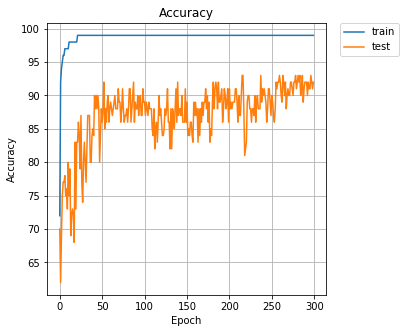

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))
plt.plot(range(len(train_m)), train_m, label="train")
plt.plot(range(len(test_m)), test_m, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.title('Accuracy')

Text(0.5,1,'LogLoss')

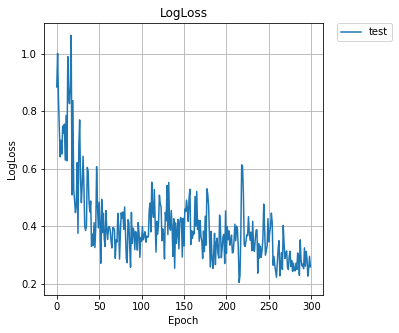

In [25]:
#import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize=(5, 5))
#plt.plot(range(len(train_m_loss)), train_m_loss, label="train")
plt.plot(range(len(test_m_loss)), test_m_loss, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('LogLoss')
plt.xlabel('Epoch')
plt.grid(True)
plt.title('LogLoss')